In [1]:
# run()

In [2]:
from agent.base import Agent
from optimization.Optimizer import PyTorchObjective

import matplotlib.pyplot as plt

# gym_gvgai.dir

%matplotlib inline
import gym
import gvgai
from IPython import display

In [3]:
def show_state(env, step=0, name="", info="", image=None):
    """Fn to visualize the agent playing the game in a notebook
    """
    plt.figure(10)
    plt.clf()
    if image is not None:
        im = image
    else:
        im = env.render(mode="rgb_array")[0]
    plt.imshow(im)
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [4]:
from generator.env_gen_wrapper import GridGame

In [5]:
from agent.base import simulate

In [6]:
import numpy as np

In [7]:
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

In [8]:
from agent.NNagent import NNagent

In [9]:
import torch

In [22]:
def make():
    def _make():
        return GridGame(game='dzelda', 
                          play_length=1000, 
                          path='./levels',
                          lvl_name='1.txt',
                          mechanics=['+', 'g'], # monsters, key, door, wall
                          images=True,
                  )
    return _make

In [11]:
from baselines.common.vec_env.shmem_vec_env import ShmemVecEnv

In [36]:
from baselines.a2c import a2c

In [12]:
from utils.utils import zelda_spaces

In [23]:
env = [make(), make()]

In [24]:
envs = ShmemVecEnv(env, 
                   spaces=zelda_spaces, 
                   context='fork')

In [25]:
envs

In [26]:
envs.step_async([0, 4])

In [27]:
[pipe.poll() for pipe in envs.parent_pipes]

[True, True]

In [28]:
obs, reward, done, info = envs.step_wait()

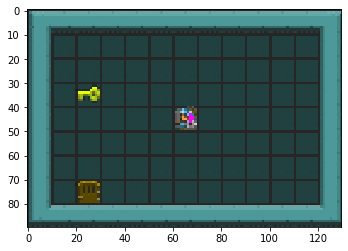

In [30]:
plt.imshow(info[0]['pic'])

In [31]:
envs.close()

In [33]:
obs.shape

(2, 13, 9, 13)

- kill oldest.   

- Write mutate wrapper that lives at top of Pair that will create a new Pair obj  
- Copy the Agent, mutate the env.  

- Flip fiber bits in the Tensor NN input.  

----  
- Interestingly, POET has a default of `max_children=8` for each reporduce step. 

In [ ]:
popLim = 2
population = [None]*popLim

for i in range(len(population)):
    population[i] = NNagent(GridGame(game='zelda', 
                                     play_length=1000,
                                     path='./levels',
                                     lvl_name='start.txt', 
                                     mechanics=['1', '2', '3', '+', 'g', 'w'], # monsters, key, door, wall
                                     images=False
                                  )
                         )

population.append(NNagent(GridGame(game='zelda', 
                                     play_length=1000,
                                     path='./levels',
                                     lvl_name='start.txt', 
                                     mechanics=['1', '2', '3', '+', 'g', 'w'], # monsters, key, door, wall
                                     images=False
                                  ), 
                          parent=torch.load("./25_gen_weights_5_5.pt")
                         )
                 )

tile = population[0].reset()

import time
start = time.time()
population[2].evaluate()
end = time.time() - start
print(end)

In [ ]:
population

In [ ]:
from optimization.Optimizer import run_opt_n_steps

In [ ]:
steps_between_transfer = 2
steps_between_mutation = 10

In [ ]:
for epochs in range(3):
    for i in range(len(population)):
        population[i].fitness(noisy=True)
    
    print('evaluated')
    if epochs % steps_between_mutation == 0:
        for i in range(len(population)):
            for _ in range(2):
                population.append(population[i].mutate(0.7))
                
        population = sorted(population, key=lambda x: x.env.id, reverse=True)[:10] 
        print(f"parents + children = {len(population)} old + new members")
        
    # sort by id, kill Pairs with smallest IDs. 
    print(f"generation has {len(population)} members")
    
    opt_wrapper = [PyTorchObjective(agent) for agent in population]
    
    print('optimizing')
    for each_pair in opt_wrapper:
        ans = run_opt_n_steps(each_pair, n=2, popsize=24)
        each_pair.update_nn(ans)

        
    if epochs % steps_between_transfer == 0:
        print('transferring')
        # for each environment, i, (and therefore paired agent)
        for i, current_pair in enumerate(population):
            # save paired agent's score and network
            best = (current_pair.nn, current_pair.max_achieved_score)
            # for every other network, evaluate environment i in agent j
            for j, other_pair in enumerate(population):
                if i == j:
                    continue
                else:
                    j_score = current_pair.env.fitness(other_pair)
                    if best[1] >= j_score:
                        # updated network
                        print(f"update network {i} to {j}")
                        best = (other_pair.nn, j_score)
                        
            #transfer into environment, i, the agent, j, who performed the best.
            #
            # Potential new evaluation metric here. We keep track on how many steps the agent takes
            # therefore, what if the final score is equal to earned score / num_steps. 
            # 
            # This would differential agents who achieve the score faster with higher fitness values
            
            current_pair.nn = best[0]
            

In [ ]:
population

In [ ]:
population[8].fitness()

In [ ]:
print(str(population[3].env.generator))

In [ ]:
population[0].env.fitness(population[2])